# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/monet-generative-adversarial-network
- Data Source: https://www.kaggle.com/competitions/gan-getting-started/data (Jang et al., 2020)
- Python version: 3.13

## Data Collection and Provenance ##



## Deep Learning Problem Description ##

**Type of Learning and Task:** This is a **Generative Adversarial Network (GAN)** deep learning problem. The task is to build a GAN which can convert photos to look like paintings by Claude Monet.

**Project Goal:** Build a GAN which can convert photos to look like paintings by Claude Monet.

## Data Description ##

The dataset contains 300 Monet paintings sized 256x256 in JPEG format and 7028 photos sized 256x256 in JPEG format. (Jang et al., 2020)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import PIL.Image as Image
import pathlib
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from tensorflow.keras.utils import load_img, img_to_array
from scipy.ndimage import generic_filter
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# Exploratory Data Analysis #

## Data Loading ##


In [7]:
def load_images(image_files, parent_path):
    r_pixels = []
    g_pixels = []
    b_pixels = []
    image_arrays = []
    for filename in image_files:
        img_path = os.path.join(parent_path, filename)
        img = load_img(img_path)  # Load at original size
        img_array = img_to_array(img).astype(np.uint8)  # Shape: (height, width, 3)
        image_arrays.append(img_array)

        # Flatten and append to respective channels
        r_pixels.extend(img_array[:, :, 0].flatten())
        g_pixels.extend(img_array[:, :, 1].flatten())
        b_pixels.extend(img_array[:, :, 2].flatten())

        return image_arrays, r_pixels, g_pixels, b_pixels


monet_path = 'data/monet_jpg'
photos_path = 'data/photo_jpg'
monet_image_files = [f for f in os.listdir(monet_path) if f.endswith('.jpg')]
photo_image_files = [f for f in os.listdir(photos_path) if f.endswith('.jpg')]

print(f"Loading {len(monet_image_files)} monet images...")
monet_image_arrays, monet_r_pixels, monet_g_pixels, monet_b_pixels = load_images(monet_image_files, monet_path)

print(f"Loading {len(photo_image_files)} photo images...")
photo_image_arrays, photo_r_pixels, photo_g_pixels, photo_b_pixels = load_images(photo_image_files, photos_path)







Loading 300 monet images...
Loading 7038 photo images...


## Data Exploration and Visualization ##

We will start by exploring the distribution of pixel intensity in each channel (RGB) in the monet images vs the photos.




Computing histograms...


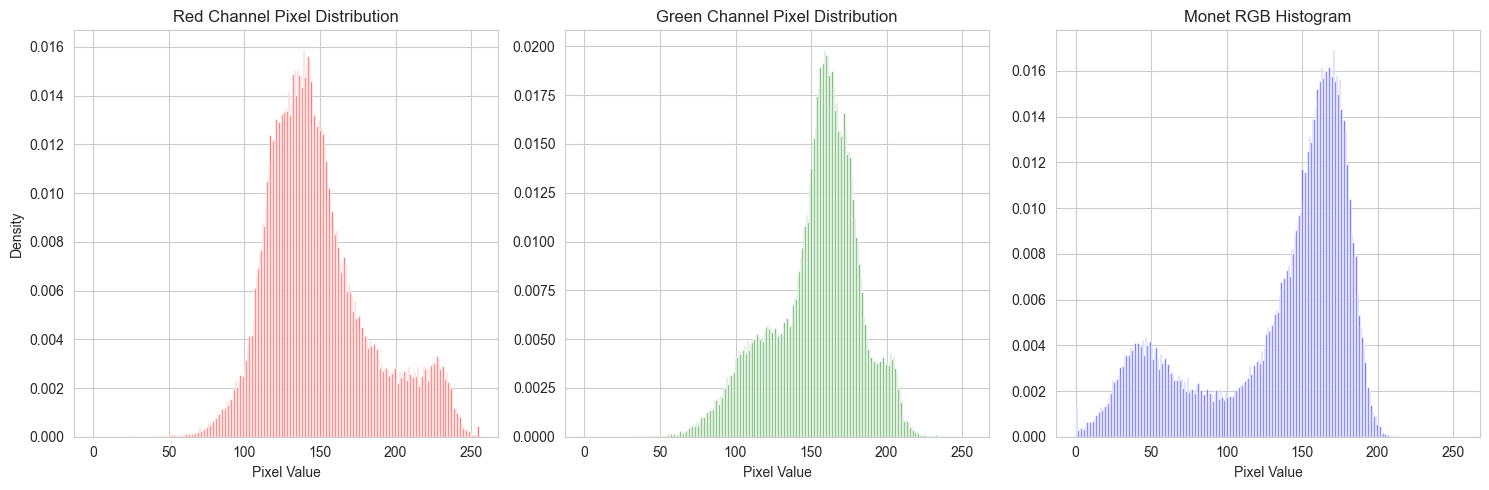

Computing histograms...


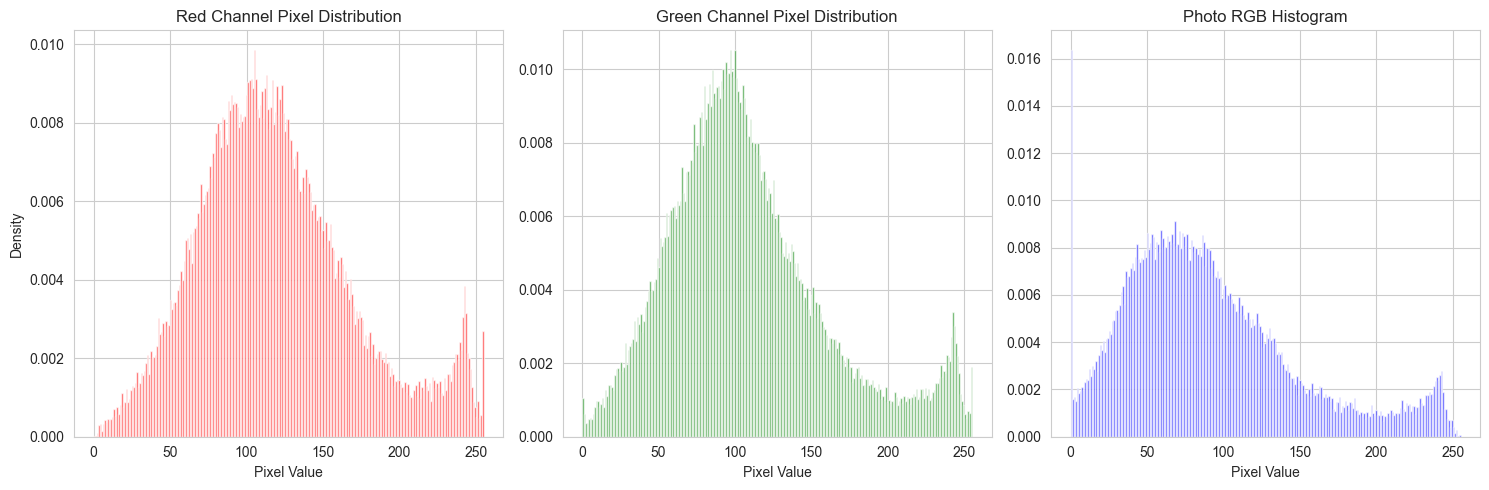


******Monet RGB Statistics******

Total pixels analyzed: 65,536
Red channel - Mean: 148.61, Std: 34.41
Green channel - Mean: 153.40, Std: 28.97
Blue channel - Mean: 133.50, Std: 49.41

******Photo RGB Statistics******

Total pixels analyzed: 65,536
Red channel - Mean: 118.88, Std: 50.92
Green channel - Mean: 107.99, Std: 52.22
Blue channel - Mean: 90.99, Std: 56.61


In [11]:
def display_rgb_histograms(r_pixels, g_pixels, b_pixels, title):
    print("Computing histograms...")

    r_pixels = np.array(r_pixels)
    g_pixels = np.array(g_pixels)
    b_pixels = np.array(b_pixels)

    # Create histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Red channel
    axes[0].hist(r_pixels, bins=256, range=(0, 255), color='red', alpha=0.7, density=True)
    axes[0].set_title('Red Channel Pixel Distribution')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Density')

    # Green channel
    axes[1].hist(g_pixels, bins=256, range=(0, 255), color='green', alpha=0.7, density=True)
    axes[1].set_title('Green Channel Pixel Distribution')
    axes[1].set_xlabel('Pixel Value')

    # Blue channel
    axes[2].hist(b_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7, density=True)
    axes[2].set_title('Blue Channel Pixel Distribution')
    axes[2].set_xlabel('Pixel Value')

    plt.title(title)
    plt.tight_layout()
    plt.show()


def print_pixel_stats(r_pixels, g_pixels, b_pixels, title):

    r_pixels = np.array(r_pixels)
    g_pixels = np.array(g_pixels)
    b_pixels = np.array(b_pixels)

    print("")
    print(f"******{title}******")
    print("")
    print(f"Total pixels analyzed: {len(r_pixels):,}")
    print(f"Red channel - Mean: {r_pixels.mean():.2f}, Std: {r_pixels.std():.2f}")
    print(f"Green channel - Mean: {g_pixels.mean():.2f}, Std: {g_pixels.std():.2f}")
    print(f"Blue channel - Mean: {b_pixels.mean():.2f}, Std: {b_pixels.std():.2f}")


display_rgb_histograms(monet_r_pixels, monet_g_pixels, monet_b_pixels, "Monet RGB Histogram")
display_rgb_histograms(photo_r_pixels, photo_g_pixels, photo_b_pixels, "Photo RGB Histogram")

print_pixel_stats(monet_r_pixels, monet_g_pixels, monet_b_pixels, "Monet RGB Statistics")
print_pixel_stats(photo_r_pixels, photo_g_pixels, photo_b_pixels, "Photo RGB Statistics")



**Results**
We can see significant differences in the average and standard deviation of pixel values when comparing money to photos.

**Further Analysis**
I hypothesize that the photos include far more "sharp lines" than the monet images. To analyze this, I will calculate the maximum pixel intensity difference for every 5x5 pixel block. Large differences indicate sharp lines. I will do this in gray scale to measure the difference across all three channels. (GeeksforGeeks, 2025)

Total blocks analyzed: 63,504


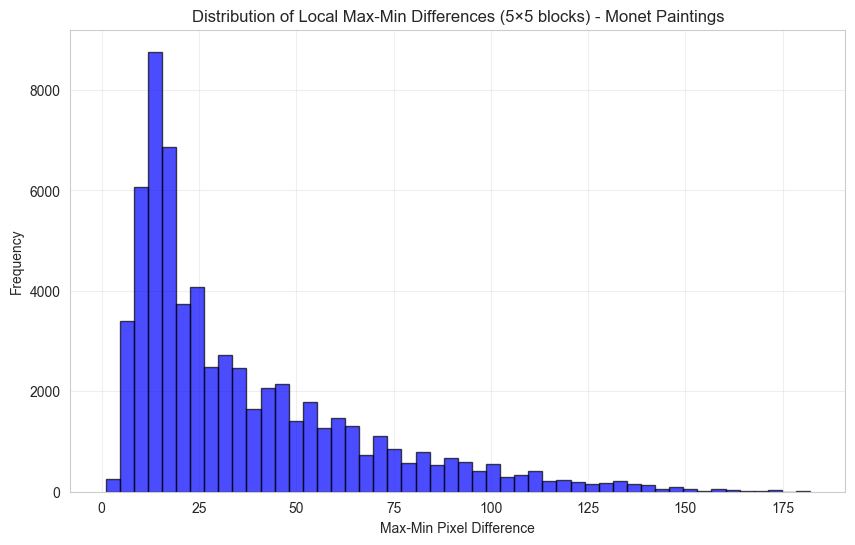


Sharpness statistics across all blocks:
Mean max-min difference: 36.40
Median: 25.00
Std: 29.96
Max difference: 182
Percentage of blocks with diff > 50: 25.0%
Percentage of blocks with diff > 100: 4.9%
Total blocks analyzed: 63,504


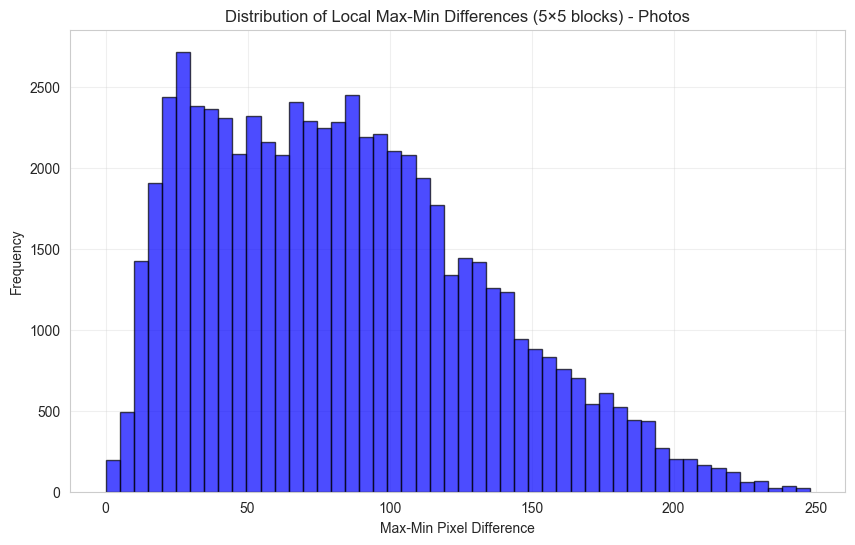


Sharpness statistics across all blocks:
Mean max-min difference: 84.09
Median: 79.00
Std: 48.59
Max difference: 248
Percentage of blocks with diff > 50: 70.5%
Percentage of blocks with diff > 100: 34.8%


In [14]:
def plot_max_intensity_distribution(img_arrays, title):
    # Collect all local max differences
    all_max_diffs = []

    for img_array in img_arrays:

        # Convert to grayscale (GeeksforGeeks, 2025)
        gray_img = np.dot(img_array.astype(np.float32), [0.299, 0.587, 0.114]).astype(np.uint8)

        # Apply 5x5 sliding window max-min difference
        # We'll use stride 1 for detailed analysis
        height, width = gray_img.shape
        block_size = 5

        for i in range(0, height - block_size + 1):
            for j in range(0, width - block_size + 1):
                block = gray_img[i:i+block_size, j:j+block_size]
                max_diff = block.max() - block.min()
                all_max_diffs.append(max_diff)

    print(f"Total blocks analyzed: {len(all_max_diffs):,}")

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_max_diffs, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of Local Max-Min Differences (5×5 blocks) - {title}')
    plt.xlabel('Max-Min Pixel Difference')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

    # Statistics
    all_max_diffs = np.array(all_max_diffs)
    print(f"\nSharpness statistics across all blocks:")
    print(f"Mean max-min difference: {all_max_diffs.mean():.2f}")
    print(f"Median: {np.median(all_max_diffs):.2f}")
    print(f"Std: {all_max_diffs.std():.2f}")
    print(f"Max difference: {all_max_diffs.max()}")
    print(f"Percentage of blocks with diff > 50: {(all_max_diffs > 50).mean()*100:.1f}%")
    print(f"Percentage of blocks with diff > 100: {(all_max_diffs > 100).mean()*100:.1f}%")


plot_max_intensity_distribution(monet_image_arrays, 'Monet Paintings')
plot_max_intensity_distribution(photo_image_arrays, 'Photos')


**Results:**
The hypothesis was correct. The monet paintings tend to have a very low difference between min and max pixel intensity compared to the photos. This is related to the soft edges and blurred appearance of monets paintings.

## Plan of Analysis ##

## Data Cleaning and Preparation ##

## Model Architecture ##

## Hyperparameter Tuning ##


# Results and Analysis #

# Conclusion #

## Summary of Results ##


## Learnings and Takeaways ##


## Things That Did Not Work as Expected ##


## Future Improvements ##



# Citations #

- GeeksforGeeks. (2025, September 23). Python: Grayscaling of images using opencv. https://www.geeksforgeeks.org/python/python-grayscaling-of-images-using-opencv/
- Jang, A., Uzsoy, A. S., & Culliton, P. (2020). I’m something of a painter myself. Kaggle. https://www.kaggle.com/competitions/gan-getting-started/data